### Predict El Nino Southern Oscillation with CICMoD dataset

In this project we work with **C**limate **I**ndex **C**ollection based on **Mo**del **D**ata (CICMoD) dataset (https://github.com/MarcoLandtHayen/climate_index_collection) to predict sea-surface temperature (SST) anomalies related to El Nino Southern Oscillation (ENSO). Several SST anomaly indices are included in CICMoD dataset, area-averaged over different regions of Tropical Pacific. Most prominent is the ENSO 3.4 index ("ENSO_34"), which focusses on Nino 3.4 region. We will use this index with various time lags (0, 1, 2, 3, 6 months) as **target**. The remaining indices included in CICMoD serve as **input** time series. **Note:** We won't use the other ENSO indices as inputs, due to expected high correlation to our target.

**Outline in this experiment:**
- Create **time lagged target indices** from ENSO34.
- Check how remaining input time series **correlate** to lagged target indices.
- Train **CNN/fc** model.
- (Hyper-)parameter **optimization**.
- Try plain-vanilla **LSTM/fc** model.
- Add various **Attention** mechanisms to LSTM/fc model: Try to find simple form for **input** and **temporal** attention.
- Try **ESN model with LRP** as alternative.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    LSTM,
    Conv1D,
    MaxPooling1D,
    Dropout,
    Flatten,
    BatchNormalization,
    LeakyReLU,
    concatenate,
)
from tensorflow.keras.optimizers import (
    SGD,
    Adam,
)
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.activations import relu
from cicmod_application.preprocessing import split_sequence

from numpy.testing import assert_allclose, assert_almost_equal

### Load data

Load collection of climate indices directly from GitHub release.

In [2]:
data_url = (
    "climate_indices.csv"
)
climind = pd.read_csv(data_url)

# Set index:
climind = climind.set_index(["model","year","month","index"]).unstack(level=-1)["value"]
climind

index                  AMO   ENSO_12    ENSO_3   ENSO_34    ENSO_4    NAO_PC  \
model year month                                                               
CESM  1    1     -0.045584  0.878723  1.793537  2.277095  1.539571  1.494980   
           2     -0.055288  0.871110  1.725915  1.881192  1.460391  0.628604   
           3      0.000295  0.641493  1.292365  1.510816  1.266292  1.332836   
           4      0.017316  0.373644  0.930377  1.034762  0.775709  0.226980   
           5      0.031327 -0.038862  0.335949  0.702846  0.743190  0.995570   
...                    ...       ...       ...       ...       ...       ...   
FOCI  1000 8      0.178689  0.522490  1.009402  1.137735  1.011215  0.906418   
           9      0.098525  0.310882  0.931236  1.269963  1.355198  0.669222   
           10     0.012815  0.201341  0.842481  1.186615  1.407205  0.515824   
           11    -0.028865  0.250733  0.882067  1.289584  1.747254 -0.928136   
           12    -0.006059  0.284155  0.622142  1.097104  1.292274 -0.762554   

index               NAO_ST        NP    PDO_PC  PREC_SAHEL  ...   SSS_ENA  \
model year month                                            ...             
CESM  1    1      1.571751 -0.624027  0.354552   -0.000226  ...  0.377755   
           2      1.635490 -0.794662  0.391417   -0.002575  ...  0.088257   
           3      0.489595 -1.425871  0.566098   -0.095461  ...  0.121279   
           4      0.473761 -0.272417  0.879974   -0.121519  ...  0.204674   
           5      2.401551 -0.381626  1.086773    0.400654  ... -0.174217   
...                    ...       ...       ...         ...  ...       ...   
FOCI  1000 8      1.207901 -0.204993 -0.748606    0.684613  ... -0.903461   
           9      1.404237  0.132056 -0.420135    0.739803  ... -1.069282   
           10     1.190851 -0.353718 -0.232508   -0.029205  ... -1.003289   
           11    -1.419175  1.089200 -0.381073   -0.004869  ... -0.674776   
           12    -0.685174  0.324010 -0.595900    0.072165  ... -0.616161   

index               SSS_NA    SSS_SA   SSS_WNA  SST_ESIO  SST_HMDR   SST_MED  \
model year month                                                               
CESM  1    1      0.361125 -0.650658  0.001022  0.483008  0.070793  0.032231   
           2      0.084034 -0.552023 -0.027617  0.602004  0.141540  0.036850   
           3      0.091827 -0.383901 -0.117263  0.359004  0.199297 -0.004955   
           4      0.097583 -0.218266 -0.047506  0.066606  0.152572 -0.107935   
           5     -0.365616 -0.188526 -0.354763  0.090692  0.205236 -0.138338   
...                    ...       ...       ...       ...       ...       ...   
FOCI  1000 8     -0.571605 -0.096008  0.587311 -0.194002  0.054469  0.091777   
           9     -0.607013 -0.043860  0.796168 -0.228907  0.053131  0.274988   
           10    -0.415460  0.055235  0.992450  0.001155 -0.029871  0.225920   
           11    -0.078932  0.135558  0.973861  0.029547 -0.074635  0.077247   
           12    -0.049702  0.477039  0.880939  0.191145 -0.241239  0.089911   

index              SST_TNA   SST_TSA  SST_WSIO  
model year month                                
CESM  1    1      0.038024  0.526206 -0.316788  
           2      0.070549  0.416427 -0.276104  
           3      0.160956  0.378252 -0.186131  
           4      0.023744  0.319001 -0.130724  
           5     -0.041518  0.126895 -0.144448  
...                    ...       ...       ...  
FOCI  1000 8      0.026577  0.050525  0.123432  
           9      0.030738 -0.008511  0.028916  
           10    -0.087775 -0.100116  0.055975  
           11    -0.167492 -0.162180  0.172732  
           12    -0.279017  0.093415 -0.048286  

[23988 rows x 29 columns]

### Prepare inputs and targets

Most prominent is the ENSO 3.4 index ("ENSO_34"), which focusses on Nino 3.4 region. We will use this index with various time lags (0, 1, 2, 3, 6 months) as **target**. The remaining indices included in CICMoD serve as **input** time series. **Note:** We will exclude *all* ENSO indices from inputs, due to expected high correlation to our target.

In [3]:
# Separate data by model, reset index and drop columns year and month:
climind_FOCI = climind.loc[('FOCI')].reset_index().drop(columns=['year','month'])
climind_CESM = climind.loc[('CESM')].reset_index().drop(columns=['year','month'])

# Exclude ENSO indices to form input features:
input_FOCI = climind_FOCI.loc[:, ["ENSO" not in col for col in climind_FOCI.columns]]
input_CESM = climind_CESM.loc[:, ["ENSO" not in col for col in climind_CESM.columns]]

# Extract ENSO_34 index:
target_FOCI = climind_FOCI.loc[:, climind_FOCI.columns == 'ENSO_34']
target_CESM = climind_CESM.loc[:, climind_CESM.columns == 'ENSO_34']

# Create lagged targets with time lag 1, 2, 3, 6 months:
target_FOCI_lag1 = target_FOCI['ENSO_34'][1:-5].values
target_FOCI_lag2 = target_FOCI['ENSO_34'][2:-4].values
target_FOCI_lag3 = target_FOCI['ENSO_34'][3:-3].values
target_FOCI_lag6 = target_FOCI['ENSO_34'][6:].values
target_CESM_lag1 = target_CESM['ENSO_34'][1:-5].values
target_CESM_lag2 = target_CESM['ENSO_34'][2:-4].values
target_CESM_lag3 = target_CESM['ENSO_34'][3:-3].values
target_CESM_lag6 = target_CESM['ENSO_34'][6:].values

# Erase last 6 rows from inputs and unlagged target, to keep dimensions right:
input_FOCI = input_FOCI[:-6]
input_CESM = input_CESM[:-6]
target_FOCI = target_FOCI[:-6]
target_CESM = target_CESM[:-6]

# Add lagged targets as new columns:
target_FOCI['ENSO_34_lag1'] = target_FOCI_lag1
target_FOCI['ENSO_34_lag2'] = target_FOCI_lag2
target_FOCI['ENSO_34_lag3'] = target_FOCI_lag3
target_FOCI['ENSO_34_lag6'] = target_FOCI_lag6
target_CESM['ENSO_34_lag1'] = target_CESM_lag1
target_CESM['ENSO_34_lag2'] = target_CESM_lag2
target_CESM['ENSO_34_lag3'] = target_CESM_lag3
target_CESM['ENSO_34_lag6'] = target_CESM_lag6

# Check dimensions:
print("FOCI inputs shape (time steps, features): ", input_FOCI.shape)
print("CESM inputs shape (time steps, features): ", input_CESM.shape)
print("\nFOCI target shape (time steps, features): ", target_FOCI.shape)
print("CESM target shape (time steps, features): ", target_CESM.shape)

FOCI inputs shape (time steps, features):  (11994, 25)
CESM inputs shape (time steps, features):  (11982, 25)

FOCI target shape (time steps, features):  (11994, 5)
CESM target shape (time steps, features):  (11982, 5)


In [4]:
climind.loc['FOCI'][:7]

index            AMO   ENSO_12    ENSO_3   ENSO_34    ENSO_4    NAO_PC  \
year month                                                               
1    1     -0.219941 -0.418755 -0.526740 -1.059218 -1.527718  1.284792   
     2     -0.225208 -0.639844 -0.317720 -0.895329 -1.333977  0.774386   
     3     -0.229436 -0.580822 -0.706647 -0.844423 -0.935197  2.113903   
     4     -0.298131 -0.499917 -0.706945 -0.796121 -1.001423  0.871025   
     5     -0.287088 -0.773396 -0.857171 -0.909040 -1.055044  0.327722   
     6     -0.273502 -0.295067 -1.020908 -1.437098 -1.470296 -0.367974   
     7     -0.376633 -0.396571 -1.181759 -1.446110 -1.541315  0.471256   

index         NAO_ST        NP    PDO_PC  PREC_SAHEL  ...   SSS_ENA    SSS_NA  \
year month                                            ...                       
1    1      1.759956  1.329107  0.840632   -0.004637  ... -1.707377 -1.558642   
     2      1.040051  0.833187  0.440410   -0.003793  ... -1.724141 -1.636935   
     3      3.744932  0.112245  0.403186   -0.016343  ... -1.465051 -1.373869   
     4      3.031612  0.244622  0.634808    0.007748  ... -1.227873 -1.198022   
     5      0.636785  0.321034 -0.053930    0.389634  ... -0.936620 -1.120277   
     6     -0.214953 -0.070430 -0.103263   -0.432813  ... -0.592182 -0.953240   
     7      0.396458  0.201960  0.219589    0.663845  ... -0.434068 -0.824139   

index         SSS_SA   SSS_WNA  SST_ESIO  SST_HMDR   SST_MED   SST_TNA  \
year month                                                               
1    1      0.040546 -0.246855 -0.195163 -0.017624 -0.090417 -0.112413   
     2     -0.725104 -0.418392 -0.215205  0.036392 -0.082168  0.035603   
     3     -0.580249 -0.398927 -0.142492  0.148457 -0.061627  0.105170   
     4      0.358499 -0.483273 -0.288952  0.019601 -0.108702 -0.011104   
     5     -0.284303 -0.425402 -0.322461 -0.034819 -0.287627 -0.004429   
     6     -0.429254 -0.175777 -0.206840 -0.172123 -0.374628 -0.149496   
     7     -0.475109 -0.109686 -0.258772 -0.064463 -0.280514 -0.321400   

index        SST_TSA  SST_WSIO  
year month                      
1    1      0.240405  0.045959  
     2      0.246774 -0.093933  
     3      0.087022 -0.035124  
     4     -0.023881 -0.075823  
     5      0.005617 -0.074538  
     6      0.100022 -0.199019  
     7      0.144748 -0.193905  

[7 rows x 29 columns]

In [5]:
input_FOCI[:7]

index,AMO,NAO_PC,NAO_ST,NP,PDO_PC,PREC_SAHEL,SAM_PC,SAM_ZM,SAT_N_ALL,SAT_N_LAND,...,SSS_ENA,SSS_NA,SSS_SA,SSS_WNA,SST_ESIO,SST_HMDR,SST_MED,SST_TNA,SST_TSA,SST_WSIO
0,-0.219941,1.284792,1.759956,1.329107,0.840632,-0.004637,0.797896,-0.295492,-1.259906,-0.481596,...,-1.707377,-1.558642,0.040546,-0.246855,-0.195163,-0.017624,-0.090417,-0.112413,0.240405,0.045959
1,-0.225208,0.774386,1.040051,0.833187,0.440410,-0.003793,0.663259,0.530890,-0.208662,0.306440,...,-1.724141,-1.636935,-0.725104,-0.418392,-0.215205,0.036392,-0.082168,0.035603,0.246774,-0.093933
2,-0.229436,2.113903,3.744932,0.112245,0.403186,-0.016343,1.185530,1.684005,-0.143442,0.332823,...,-1.465051,-1.373869,-0.580249,-0.398927,-0.142492,0.148457,-0.061627,0.105170,0.087022,-0.035124
3,-0.298131,0.871025,3.031612,0.244622,0.634808,0.007748,1.002520,1.409169,0.441968,0.907260,...,-1.227873,-1.198022,0.358499,-0.483273,-0.288952,0.019601,-0.108702,-0.011104,-0.023881,-0.075823
4,-0.287088,0.327722,0.636785,0.321034,-0.053930,0.389634,1.199113,0.984511,-1.571767,-1.163302,...,-0.936620,-1.120277,-0.284303,-0.425402,-0.322461,-0.034819,-0.287627,-0.004429,0.005617,-0.074538
5,-0.273502,-0.367974,-0.214953,-0.070430,-0.103263,-0.432813,0.527094,-0.089467,-0.504685,-0.397058,...,-0.592182,-0.953240,-0.429254,-0.175777,-0.206840,-0.172123,-0.374628,-0.149496,0.100022,-0.199019
6,-0.376633,0.471256,0.396458,0.201960,0.219589,0.663845,0.204183,-0.714143,-0.675508,-0.510068,...,-0.434068,-0.824139,-0.475109,-0.109686,-0.258772,-0.064463,-0.280514,-0.321400,0.144748,-0.193905


In [6]:
target_FOCI[:7]

index,ENSO_34,ENSO_34_lag1,ENSO_34_lag2,ENSO_34_lag3,ENSO_34_lag6
0,-1.059218,-0.895329,-0.844423,-0.796121,-1.446110
1,-0.895329,-0.844423,-0.796121,-0.909040,-1.045341
2,-0.844423,-0.796121,-0.909040,-1.437098,-1.079959
3,-0.796121,-0.909040,-1.437098,-1.446110,-1.055753
4,-0.909040,-1.437098,-1.446110,-1.045341,-0.898141
5,-1.437098,-1.446110,-1.045341,-1.079959,-0.892044
6,-1.446110,-1.045341,-1.079959,-1.055753,-0.762195


### Check correlation

Next we check, how remaining input features correlate to lagged targets.

<AxesSubplot:title={'center':'Correlation of input features with lagged target series'}, xlabel='index', ylabel='index'>

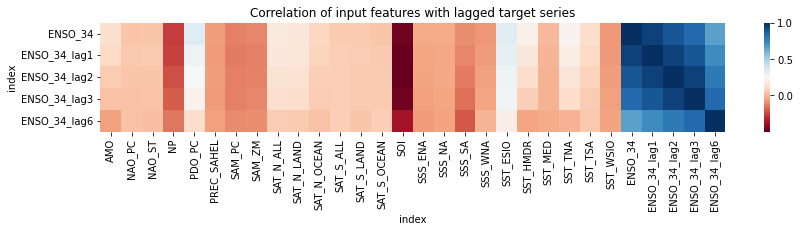

In [7]:
# Plot correlation of inputs and lagged target series as heatmap:
fig, ax = plt.subplots(figsize=(14,2))
plt.title('Correlation of input features with lagged target series')
sns.heatmap(pd.concat([input_FOCI, target_FOCI], axis=1).corr()[-5:], cmap="RdBu", xticklabels=True, yticklabels=True)

### Discussion on correlation check

Find inputs and targets to be **mostly un-correlated**. If at all, we see some minor correlation between PC-based Pacific Decadal Oscillation (PDO_PC) or Eastern Subtropical Indian Ocean sea-surface temperature anomaly (SST_ESIO) and ENSO3.4 index (ENSO_34). Correlation coefficient reads 0.34 and 0.33, respectively.

### Continue data pre-processing

We now continue to prepare inputs and targets:

- Split sequences into samples of specified input length.
- Split inputs and targets into train and validation sets.
- Optionally scale or normalize inputs according to statistics obtained only from train data.

In [53]:
## Set parameters for inputs and target:

# Select input features:
input_features = [
    'AMO', 'NAO_PC', 'NAO_ST', 'NP', 'PDO_PC', 'PREC_SAHEL', 'SAM_PC', 'SAM_ZM', 'SAT_N_ALL', 'SAT_N_LAND',
    'SAT_N_OCEAN', 'SAT_S_ALL', 'SAT_S_LAND', 'SAT_S_OCEAN', 'SOI', 'SSS_ENA', 'SSS_NA', 'SSS_SA', 'SSS_WNA',
    'SST_ESIO', 'SST_HMDR', 'SST_MED', 'SST_TNA', 'SST_TSA', 'SST_WSIO'
]

# Select target:
target_horizon = ['ENSO_34','ENSO_34_lag3']

# Specify input length:
input_length = 24  # months

# Specify relative amount of train data:
train_val_split = 0.8

## Optionally choose to scale or normalize input features:
# 'no': Keep raw input features.
# 'scale_01': Scale input features with min/max scaling to [0,1].
# 'scale_11': Scale input features with min/max scaling to [-1,1].
# 'norm': Normalize input features, hence subtract mean and divide by std dev.
scale_norm = 'scale_11' #'norm' #'scale_01'

In [54]:
# Select specified input features:
inputs_selected_FOCI = input_FOCI[input_features]
inputs_selected_CESM = input_CESM[input_features]

# Select target horizon:
target_selected_FOCI = target_FOCI[target_horizon]
target_selected_CESM = target_CESM[target_horizon]

# Split input values into sequences of specified input length:
inputs_split_FOCI = split_sequence(inputs_selected_FOCI, input_length)
inputs_split_CESM = split_sequence(inputs_selected_CESM, input_length)

# Adjust targets: Cut first (input_length - 1) entries:
target_cut_FOCI = target_selected_FOCI[input_length-1:]
target_cut_CESM = target_selected_CESM[input_length-1:]

In [55]:
## Split inputs and targets into train and validation sets:

# Get number of train samples:
n_train = int(train_val_split * len(inputs_split_FOCI))

# Split inputs and targets:
train_input_FOCI = inputs_split_FOCI[:n_train]
train_input_CESM = inputs_split_CESM[:n_train]
val_input_FOCI = inputs_split_FOCI[n_train:]
val_input_CESM = inputs_split_CESM[n_train:]

train_target_FOCI = target_cut_FOCI[:n_train]
train_target_CESM = target_cut_CESM[:n_train]
val_target_FOCI = target_cut_FOCI[n_train:]
val_target_CESM = target_cut_CESM[n_train:]

# Check dimensions:
print("FOCI: train_input shape (samples, time steps, features): ", train_input_FOCI.shape)
print("FOCI_val_input shape (samples, time steps, features): ", val_input_FOCI.shape)
print("CESM: train_input shape (samples, time steps, features): ", train_input_CESM.shape)
print("CESM_val_input shape (samples, time steps, features): ", val_input_CESM.shape)
print("\nFOCI: train_target shape (samples, features): ", train_target_FOCI.shape)
print("FOCI: val_target shape (samples, features): ", val_target_FOCI.shape)
print("CESM train_target shape (samples, features): ", train_target_CESM.shape)
print("CESM: val_target shape (samples, features): ", val_target_CESM.shape)

FOCI: train_input shape (samples, time steps, features):  (9576, 24, 25)
FOCI_val_input shape (samples, time steps, features):  (2395, 24, 25)
CESM: train_input shape (samples, time steps, features):  (9576, 24, 25)
CESM_val_input shape (samples, time steps, features):  (2383, 24, 25)

FOCI: train_target shape (samples, features):  (9576, 2)
FOCI: val_target shape (samples, features):  (2395, 2)
CESM train_target shape (samples, features):  (9576, 2)
CESM: val_target shape (samples, features):  (2383, 2)


In [56]:
## Get statistics from train data:

# Get mean, std dev, min and max for ALL input features from train data:
train_mean_FOCI = np.mean(train_input_FOCI, axis=(0,1))
train_std_FOCI = np.std(train_input_FOCI, axis=(0,1))
train_min_FOCI = np.min(train_input_FOCI, axis=(0,1))
train_max_FOCI = np.max(train_input_FOCI, axis=(0,1))
train_mean_CESM = np.mean(train_input_CESM, axis=(0,1))
train_std_CESM = np.std(train_input_CESM, axis=(0,1))
train_min_CESM = np.min(train_input_CESM, axis=(0,1))
train_max_CESM = np.max(train_input_CESM, axis=(0,1))

## Optionally scale or normalize input features as specified:

# 'scale_01': Scale input features with min/max scaling to [0,1].
if scale_norm == "scale_01":
    train_input_scaled_FOCI = (train_input_FOCI - train_min_FOCI) / (train_max_FOCI - train_min_FOCI)
    val_input_scaled_FOCI = (val_input_FOCI - train_min_FOCI) / (train_max_FOCI - train_min_FOCI)
    train_input_scaled_CESM = (train_input_CESM - train_min_CESM) / (train_max_CESM - train_min_CESM)
    val_input_scaled_CESM = (val_input_CESM - train_min_CESM) / (train_max_CESM - train_min_CESM)

# 'scale_11': Scale input features with min/max scaling to [-1,1].
if scale_norm == "scale_11":
    train_input_scaled_FOCI = 2 * (train_input_FOCI - train_min_FOCI) / (train_max_FOCI - train_min_FOCI) - 1
    val_input_scaled_FOCI = 2 * (val_input_FOCI - train_min_FOCI) / (train_max_FOCI - train_min_FOCI) - 1 
    train_input_scaled_CESM = 2 * (train_input_CESM - train_min_CESM) / (train_max_CESM - train_min_CESM) - 1
    val_input_scaled_CESM = 2 * (val_input_CESM - train_min_CESM) / (train_max_CESM - train_min_CESM) - 1

# 'norm': Normalize input features, hence subtract mean and divide by std dev.
if scale_norm == "norm":
    train_input_scaled_FOCI = (train_input_FOCI - train_mean_FOCI) / train_std_FOCI
    val_input_scaled_FOCI = (val_input_FOCI - train_mean_FOCI) / train_std_FOCI
    train_input_scaled_CESM = (train_input_CESM - train_mean_CESM) / train_std_CESM
    val_input_scaled_CESM = (val_input_CESM - train_mean_CESM) / train_std_CESM

# else: Keep raw input features.

# Check result:
print("FOCI: train_input MIN: ", np.round(np.min(train_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: train_input MAX: ", np.round(np.max(train_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: train_input MEAN: ", np.round(np.mean(train_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: train_input STD: ", np.round(np.std(train_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: val_input MIN: ", np.round(np.min(val_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: val_input MAX: ", np.round(np.max(val_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: val_input MEAN: ", np.round(np.mean(val_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: val_input STD: ", np.round(np.std(val_input_scaled_FOCI, axis=(0,1)), 2))
print("\n\nCESM: train_input MIN: ", np.round(np.min(train_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: train_input MAX: ", np.round(np.max(train_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: train_input MEAN: ", np.round(np.mean(train_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: train_input STD: ", np.round(np.std(train_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: val_input MIN: ", np.round(np.min(val_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: val_input MAX: ", np.round(np.max(val_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: val_input MEAN: ", np.round(np.mean(val_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: val_input STD: ", np.round(np.std(val_input_scaled_CESM, axis=(0,1)), 2))

FOCI: train_input MIN:  [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1.]
FOCI: train_input MAX:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
FOCI: train_input MEAN:  [-0.11 -0.13 -0.07 -0.01 -0.01 -0.39  0.15  0.15 -0.01  0.09 -0.    0.11
 -0.03  0.13  0.07 -0.06 -0.05 -0.08  0.14 -0.03  0.    0.03 -0.01  0.03
  0.02]
FOCI: train_input STD:  [0.26 0.23 0.24 0.24 0.27 0.12 0.29 0.3  0.23 0.24 0.24 0.23 0.21 0.25
 0.26 0.28 0.28 0.25 0.28 0.26 0.25 0.22 0.26 0.24 0.23]
FOCI: val_input MIN:  [-0.94 -0.85 -0.83 -0.95 -0.76 -0.88 -1.14 -1.12 -0.77 -0.8  -0.92 -0.75
 -0.83 -0.83 -0.79 -0.87 -0.99 -0.94 -0.89 -0.96 -0.81 -0.85 -1.02 -0.77
 -0.83]
FOCI: val_input MAX:  [0.95 0.78 0.89 0.85 0.84 0.56 0.98 0.93 0.97 1.12 0.87 0.81 0.91 0.85
 0.78 0.91 0.86 0.83 0.85 0.9  1.   1.03 0.83 0.83 0.97]
FOCI: val_input MEAN:  [ 0.01 -0.13 -0.07 -0.01 -0.01 -0.4   0.15  0.15  0.02  0.1   0.04  0.15
 -0.02  0.18  0.06

### Define functions for CNN/fc, LSTM/fc and CNN/LSTM models

We are going to apply different ANN model architectures. For optimizing (hyper-)parameters, it is convenient to define model architectures in a functional form:
- CNN / fc model
- LSTM / fc model
- hybrid CNN / LSTM model

**CNN / fc** model:
The model is based on a number of CNN layers. For each CNN layer the number of filters (CNN_filters) and the filter size (CNN_kernel_size) used in the convolution needs to be specified. Each CNN layer consists of the 1D convolution itself, followed by batch normalization and ReLU activation. Note: If input length is larger or equal to 20 time steps, we add max pooling (with pool_size=2) after each CNN layer, to limit the number of trainable parameters and prevent the model from overfitting. The final CNN layer's output is then flattened and used as input for the fully connected (fc) Dense layers, stacked on top of the CNN layers. Again, the number of fc layers and the number of units per layer need to be specified (both in fc_units) and the hidden activation can be chosen.

(later: Add attention to LSTM model and try ESN model.)

In [62]:
def set_CNN_fc(CNN_filters, CNN_kernel_sizes, fc_units, fc_hidden_activation, 
           n_epochs, batch_size, learning_rate, loss_function, output_activation = 'linear'):
    """
    Sets up CNN/fc model. Can be used for multi-run experiments.
    
    Parameters:
    ===========
    CNN_filters: Array of integer numbers to specify the number of feature maps in all CNN layers.
    CNN_kernel_sizes: Array of integer numbers to specify the filter sizes in all CNN layers.
    fc_units: Array of integer numbers to specify the number of units in all hidden fc layers.
    fc_hidden_activation: Activation function for hidden fc layers, 'linear' or 'sigmoid'.
    n_epochs: Integer number to specify the number of epochs for a single run.
    batch_size: Integer number to specify the batch size used for training the model.
    learning_rate: Floating point number to set the learning rate for the optimizer.
    loss_function: String ('mse', 'custom_mse', 'custom_loss') to choose the loss function.
    ouput_activation : Activation function for output layers.
    
    Returns:
    ========
    model
    
    """
    
    # Start model definition:
    model = Sequential()
    
    # Add input layer:
    input_shape = (input_length, len(input_features))
    model.add(Input(shape=input_shape))
    
    # Add CNN layer(s):
    for i in range(len(CNN_filters)):
        model.add(Conv1D(filters=CNN_filters[i], kernel_size=CNN_kernel_sizes[i], strides=1,
                         kernel_initializer=weight_init, bias_initializer = bias_init))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.3))
        
        # Add max pooling, if input_length is equal or above 40d to limit number of trainable parameters:
        if input_length >= 20:
            model.add(MaxPooling1D(pool_size=2))
    
    # Flatten CNN output:
    model.add(Flatten())
    
    # Add hidden fc layer(s):
    for i in range(len(fc_units)):
        model.add(Dense(units=fc_units[i], activation = fc_hidden_activation,
                        kernel_initializer=weight_init, bias_initializer = bias_init))
    
    # Add output unit:
    model.add(Dense(units=len(target_horizon), name = "output", activation = output_activation,
                    kernel_initializer=weight_init, bias_initializer = bias_init))

    # Compile model with desired loss function:
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function, metrics=([]))
   
    return model

In [63]:
def set_LSTM_fc(LSTM_units, fc_units, fc_hidden_activation,
           n_epochs, batch_size, learning_rate, loss_function):
    """
    Sets up LSTM/fc model. Can be used for multi-run experiments.
    
    Parameters:
    ===========
    LSTM_units: Array of integer numbers to specify the number of units in all hidden LSTM layers.
    fc_units: Array of integer numbers to specify the number of units in all hidden fc layers.
    fc_hidden_activation: Activation function for hidden fc layers, 'linear' or 'sigmoid'.
    n_epochs: Integer number to specify the number of epochs for a single run.
    batch_size: Integer number to specify the batch size used for training the model.
    learning_rate: Floating point number to set the learning rate for the optimizer.
    loss_function: String ('mse', 'custom_mse', 'custom_loss') to choose the loss function.
    
    Returns:
    ========
    model
    
    """
    
    # Start model definition:
    model = Sequential()
    
    # Add input layer:
    input_shape = (input_length, len(input_features))
    model.add(Input(shape=input_shape))
  
    # Add LSTM layer(s):
    for i in range(len(LSTM_units)):
        
        # In case we have multiple LSTM layers, we want to pass ALL hidden states to the subsequent LSTM layer.
        # Only for the last (and possibly ONLY) LSTM layer we only need the final hidden states.
        # This can be specified by return_sequences=True/False.
        # So check if we reached the last LSTM layer yet:
        if i < (len(LSTM_units) - 1):
            model.add(LSTM(units=LSTM_units[i], bias_initializer=bias_init, return_sequences=True))
        else:
            model.add(LSTM(units=LSTM_units[i], bias_initializer=bias_init, return_sequences=False))
    
    # Add hidden fc layer(s):
    for i in range(len(fc_units)):
        model.add(Dense(units=fc_units[i], activation = fc_hidden_activation,
                        kernel_initializer=weight_init, bias_initializer = bias_init))
    
    # Add output unit:
    model.add(Dense(units=1, name = "output", activation = 'linear',
                    kernel_initializer=weight_init, bias_initializer = bias_init))

    # Compile model with desired loss function:
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function, metrics=([]))
   
    return model

In [64]:
def set_CNN_LSTM(CNN_filters, CNN_kernel_sizes, LSTM_units, 
           n_epochs, batch_size, learning_rate, loss_function):
    """
    Sets up CNN/LSTM model. Can be used for multi-run experiments.
    
    Parameters:
    ===========
    CNN_filters: Array of integer numbers to specify the number of feature maps in all CNN layers.
    CNN_kernel_sizes: Array of integer numbers to specify the filter sizes in all CNN layers.
    LSTM_units: Array of integer numbers to specify the number of units in all hidden LSTM layers.
    n_epochs: Integer number to specify the number of epochs for a single run.
    batch_size: Integer number to specify the batch size used for training the model.
    learning_rate: Floating point number to set the learning rate for the optimizer.
    loss_function: String ('mse', 'custom_mse', 'custom_loss') to choose the loss function.
    
    Returns:
    ========
    model
    
    """
    
    # Start model definition:
    model = Sequential()
    
    # Add input layer:
    input_shape = (input_length, len(input_features))
    model.add(Input(shape=input_shape))
    
    # Add CNN layer(s):
    for i in range(len(CNN_filters)):
        model.add(Conv1D(filters=CNN_filters[i], kernel_size=CNN_kernel_sizes[i], strides=1,
                         kernel_initializer=weight_init, bias_initializer = bias_init))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.3))
        
        # Add max pooling, if input_length is equal or above 40d to limit number of trainable parameters:
        if input_length >= 20:
            model.add(MaxPooling1D(pool_size=2))
    
    # Add hidden LSTM layer(s):
    for i in range(len(LSTM_units)):
        
        # In case we have multiple LSTM layers, we want to pass ALL hidden states to the subsequent LSTM layer.
        # Only for the last (and possibly ONLY) LSTM layer we only need the final hidden states.
        # This can be specified by return_sequences=True/False.
        # So check if we reached the last LSTM layer yet:
        if i < (len(LSTM_units) - 1):
            model.add(LSTM(units=LSTM_units[i], bias_initializer=bias_init, return_sequences=True))
        else:
            model.add(LSTM(units=LSTM_units[i], bias_initializer=bias_init, return_sequences=False))
    
    # Add output unit:
    model.add(Dense(units=1, name = "output", activation = 'linear',
                    kernel_initializer=weight_init, bias_initializer = bias_init))

    # Compile model with desired loss function:
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function, metrics=([]))
   
    return model

### CNN / fc: Define model parameters and start single-run experiment

In [65]:
# Model parameters:
weight_init = tfi.glorot_uniform() # Taken as default.
bias_init = tfi.Zeros() # Taken as default.
CNN_filters = [10,20]
CNN_kernel_sizes = [5,5]
fc_units = [20,10]
fc_hidden_activation = relu
n_epochs = 20
batch_size = 20
learning_rate = 0.0001
loss_function = 'mse'

In [66]:
# Set up compiled CNN/fc models separately for both - FOCI and CESM:
model_FOCI_lag0 = set_CNN_fc(CNN_filters, CNN_kernel_sizes, fc_units, fc_hidden_activation,
                   n_epochs, batch_size, learning_rate, loss_function)
model_CESM_lag0 = set_CNN_fc(CNN_filters, CNN_kernel_sizes, fc_units, fc_hidden_activation,
                   n_epochs, batch_size, learning_rate, loss_function)
model_FOCI_lag0.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 20, 10)            1260      
_________________________________________________________________
batch_normalization_12 (Batc (None, 20, 10)            40        
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 20, 10)            0         
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 10, 10)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 6, 20)             1020      
_________________________________________________________________
batch_normalization_13 (Batc (None, 6, 20)             80        
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 6, 20)            

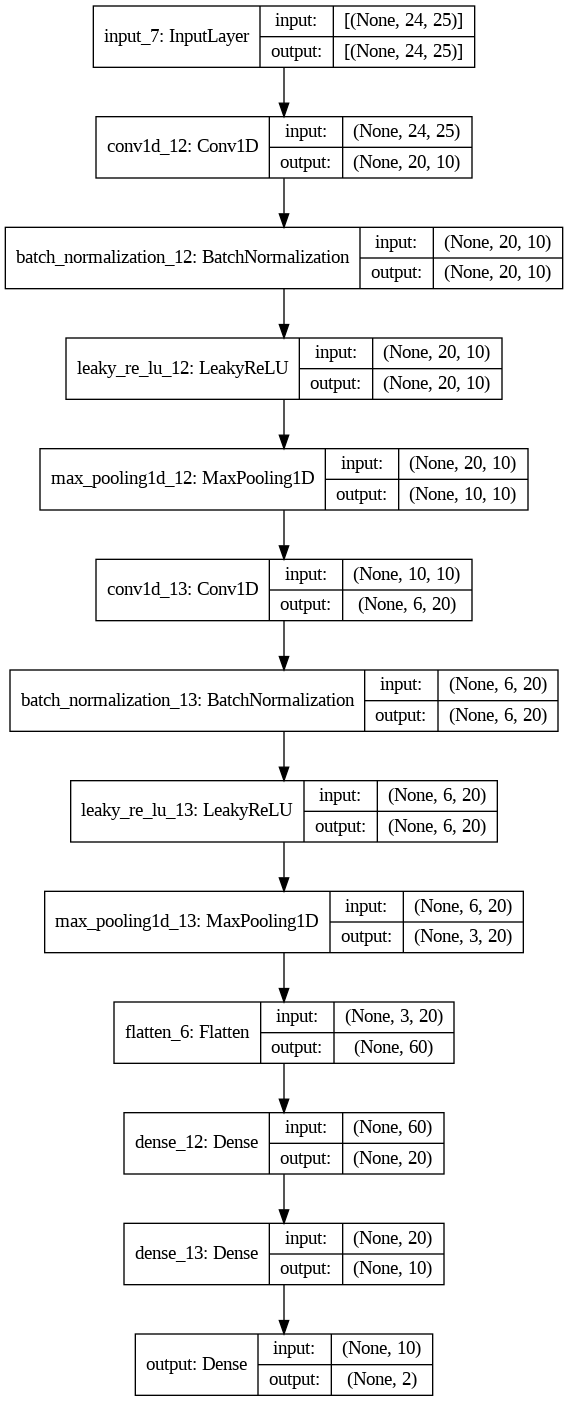

In [67]:
plot_model(model_FOCI_lag0, show_shapes=True, show_layer_names=True)

In [68]:
## Start with un-lagged ENSO3.4 index as target:

# Train model on optionally scaled or normalized inputs and specified un-scaled targets:
print("Train FOCI model")
history_FOCI_lag0 = model_FOCI_lag0.fit(train_input_scaled_FOCI, train_target_FOCI, epochs=n_epochs, batch_size=batch_size,
                    shuffle=True, verbose=2, validation_data=(val_input_scaled_FOCI, val_target_FOCI))
print("\nTrain CESM model")
history_CESM_lag0 = model_CESM_lag0.fit(train_input_scaled_CESM, train_target_CESM, epochs=n_epochs, batch_size=batch_size,
                    shuffle=True, verbose=2, validation_data=(val_input_scaled_CESM, val_target_CESM))

Train FOCI model
Epoch 1/20
479/479 - 5s - loss: 0.6630 - val_loss: 0.6069
Epoch 2/20
479/479 - 2s - loss: 0.5016 - val_loss: 0.5302
Epoch 3/20
479/479 - 2s - loss: 0.4282 - val_loss: 0.4559
Epoch 4/20
479/479 - 2s - loss: 0.3657 - val_loss: 0.4014
Epoch 5/20
479/479 - 2s - loss: 0.3188 - val_loss: 0.3518
Epoch 6/20
479/479 - 2s - loss: 0.2853 - val_loss: 0.3241
Epoch 7/20
479/479 - 2s - loss: 0.2677 - val_loss: 0.3077
Epoch 8/20
479/479 - 2s - loss: 0.2492 - val_loss: 0.2921
Epoch 9/20
479/479 - 2s - loss: 0.2386 - val_loss: 0.2870
Epoch 10/20
479/479 - 2s - loss: 0.2300 - val_loss: 0.2820
Epoch 11/20
479/479 - 2s - loss: 0.2200 - val_loss: 0.2698
Epoch 12/20
479/479 - 2s - loss: 0.2165 - val_loss: 0.2682
Epoch 13/20
479/479 - 3s - loss: 0.2080 - val_loss: 0.2601
Epoch 14/20
479/479 - 2s - loss: 0.2044 - val_loss: 0.2600
Epoch 15/20
479/479 - 3s - loss: 0.2018 - val_loss: 0.2602
Epoch 16/20
479/479 - 2s - loss: 0.1976 - val_loss: 0.2559
Epoch 17/20
479/479 - 2s - loss: 0.1962 - val_lo

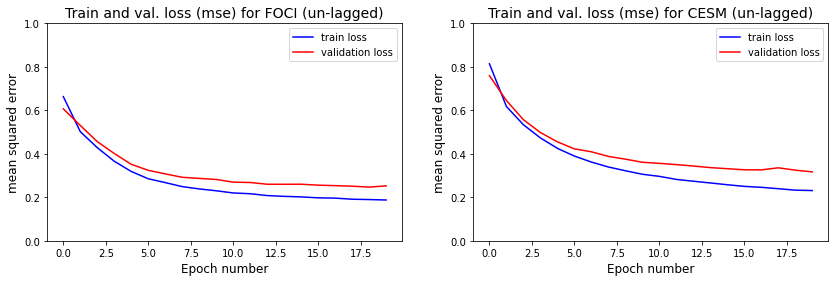

In [69]:
# Plot train and val_loss (mse):
fig, axes = plt.subplots(1, 2, figsize=(14,4))

axes[0].plot(history_FOCI_lag0.history['loss'], color = 'blue', label = 'train loss')
axes[0].plot(history_FOCI_lag0.history['val_loss'], color = 'red', label = 'validation loss')
axes[0].set_xlabel('Epoch number', fontsize=12)
axes[0].set_ylabel('mean squared error', fontsize=12)
axes[0].set_ylim([0,1])
axes[0].set_title('Train and val. loss (mse) for FOCI (un-lagged)', fontsize=14)
axes[0].legend()

axes[1].plot(history_CESM_lag0.history['loss'], color = 'blue', label = 'train loss')
axes[1].plot(history_CESM_lag0.history['val_loss'], color = 'red', label = 'validation loss')
axes[1].set_xlabel('Epoch number', fontsize=12)
axes[1].set_ylabel('mean squared error', fontsize=12)
axes[1].set_ylim([0,1])
axes[1].set_title('Train and val. loss (mse) for CESM (un-lagged)', fontsize=14)
axes[1].legend()

plt.show()

In [70]:
# Get model predictions:
train_pred_FOCI_lag0 = model_FOCI_lag0.predict(train_input_scaled_FOCI)
val_pred_FOCI_lag0 = model_FOCI_lag0.predict(val_input_scaled_FOCI)
train_pred_CESM_lag0 = model_CESM_lag0.predict(train_input_scaled_CESM)
val_pred_CESM_lag0 = model_CESM_lag0.predict(val_input_scaled_CESM)

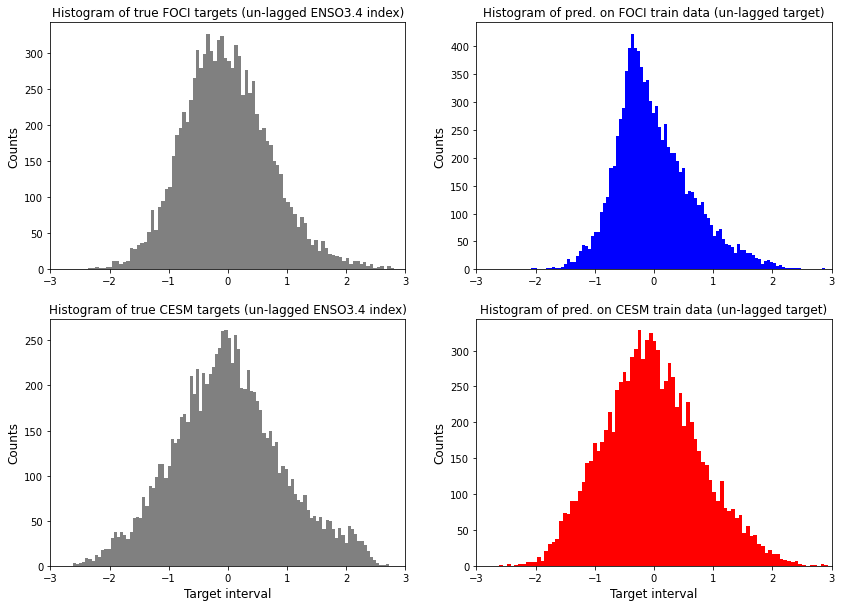

In [75]:
## Plot histogram of predictions on train data:
nBins = 100
fig, axes = plt.subplots(2, 2, figsize=(14,10))
# FOCI
axes[0,0].set_xlim([-3,3])
axes[0,0].hist(train_target_FOCI.values[:,0], nBins, color="grey")
axes[0,0].set_ylabel("Counts", fontsize=12)
axes[0,0].set_title("Histogram of true FOCI targets (un-lagged ENSO3.4 index)", fontsize=12)
axes[0,1].hist(train_pred_FOCI_lag0[:,0], nBins, color="blue")
axes[0,1].set_ylabel("Counts", fontsize=12)
axes[0,1].set_title("Histogram of pred. on FOCI train data (un-lagged target)", fontsize=12)
# CESM
axes[1,0].hist(train_target_CESM.values[:,0], nBins, color="grey")
axes[1,0].set_xlabel("Target interval", fontsize=12)
axes[1,0].set_ylabel("Counts", fontsize=12)
axes[1,0].set_title("Histogram of true CESM targets (un-lagged ENSO3.4 index)", fontsize=12)
axes[1,1].hist(train_pred_CESM_lag0[:,0], nBins, color="red")
axes[1,1].set_xlabel("Target interval", fontsize=12)
axes[1,1].set_ylabel("Counts", fontsize=12)
axes[1,1].set_title("Histogram of pred. on CESM train data (un-lagged target)", fontsize=12)
# Unifiy x limits:
axes[0,0].set_xlim([-3,3])
axes[0,1].set_xlim([-3,3])
axes[1,0].set_xlim([-3,3])
axes[1,1].set_xlim([-3,3])

plt.show()

In [72]:
# NEXT steps:

### Fidelity check: Plot true target (un-lagged ENSO3.4 index) as bar-plot with red/blue bars and add prediction
### as black line on top.

### Check cross-validation: Can we use the model trained on FOCI data to predict on CESM data, and vice versa?

### Print final train and val mse for both models.

### Discussion on single-run with un-lagged targets

### Then try to train models on lagged targets, compare results.

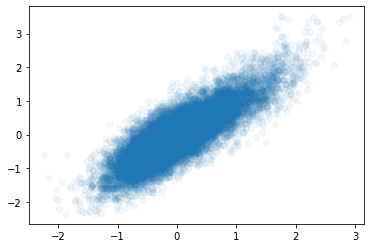

In [73]:
plt.scatter(train_pred_FOCI_lag0, train_target_FOCI, alpha = 0.05)

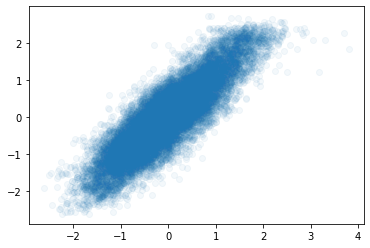

In [76]:
plt.scatter(train_pred_CESM_lag0, train_target_CESM, alpha = 0.05)

In [77]:
# Define function to specify bar color, according to sign of values:
def bar_color(data,color_pos,color_neg):
    return np.where(data.values>0,color_pos,color_neg).T

Text(0.5, 0, 'Time [month]')

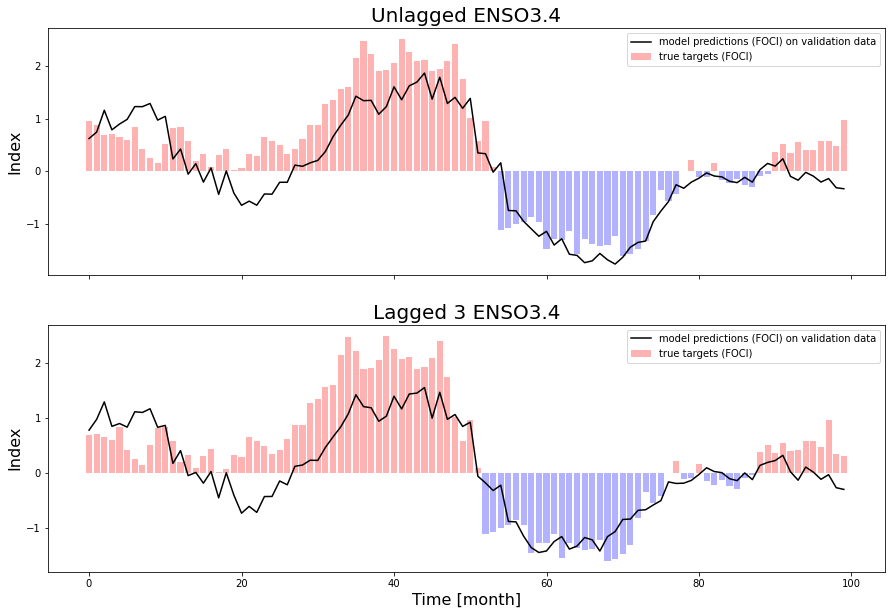

In [107]:
## Fidelity check: Plot VALIDATION targets as bar plot (red / blue) vs. predictions as black line

target_dim = lambda x, index: x[:100, index] if isinstance(x, np.ndarray) else x.iloc[:100, index]

# Plot first 1000 time steps only:
fig, axes = plt.subplots(2,1,figsize=[15,10], sharex = True)

# FOCI
axes[0].bar(
    x=range(len(target_dim(val_target_FOCI, 0))),
    height=target_dim(val_target_FOCI, 0),
    color=bar_color(target_dim(val_target_FOCI, 0),'r','b'),
    label="true targets (FOCI)",
    alpha=0.3
)
axes[0].plot(target_dim(val_pred_FOCI_lag0, 0), label="model predictions (FOCI) on validation data", color='black')
axes[0].legend()
axes[0].set_title('Unlagged ENSO3.4', fontsize=20)
axes[0].set_ylabel('Index', fontsize=16)

# FOCI
axes[1].bar(
    x=range(len(target_dim(val_target_FOCI, 1))),
    height=target_dim(val_target_FOCI, 1),
    color=bar_color(target_dim(val_target_FOCI, 1),'r','b'),
    label="true targets (FOCI)",
    alpha=0.3
)
axes[1].plot(target_dim(val_pred_FOCI_lag0, 1), label="model predictions (FOCI) on validation data", color='black')
axes[1].legend()
axes[1].set_title('Lagged 3 ENSO3.4', fontsize=20)
axes[1].set_ylabel('Index', fontsize=16)

# # CESM
# axes[1].bar(
#     x=range(len(val_target_CESM.values[:1000,0])),
#     height=val_target_CESM.values[:1000,0],
#     color=bar_color(val_target_CESM[:1000],'r','b')[0],
#     label="true targets (CESM)",
#     alpha=0.3
# )
# axes[1].plot(val_pred_CESM_lag0[:1000], label="model predictions (CESM) on validation data", color='black')
# axes[1].legend()
# axes[1].set_title('Unlagged ENSO3.4: Fidelity check of true targets vs. model predictions (CESM)', fontsize=20)
# axes[1].set_xlabel('Time [month]', fontsize=16)
# axes[1].set_ylabel('Index', fontsize=16)
axes[1].set_xlabel('Time [month]', fontsize=16)



In [102]:
bar_color(target_dim(val_target_FOCI),'r','b')[0]

'r'